In [1]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
from torch.utils.data import DataLoader


In [2]:
img_size = 28
batch_size = 128

transform_train = transforms.Compose([
	  			transforms.Resize((img_size, img_size)),
          transforms.ToTensor(),
          transforms.Normalize(0.5,0.5)
          ])

# train dataset and loader
train_dataset = dsets.FashionMNIST(train=True, download=True, root = "./", transform = transform_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15299122.51it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 277063.19it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5150795.92it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17830121.38it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Current Device : {}'.format(device))

Current Device : cuda


In [4]:
sample = next(iter(train_loader))
print(sample[0].shape) # img
print(sample[1].shape) # label

torch.Size([128, 1, 28, 28])
torch.Size([128])


### Try to sample out one data point from dataloader

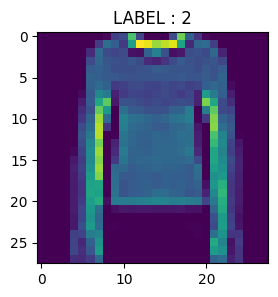

In [5]:
plot_idx = 5
fig = plt.figure(figsize=(3, 3))
plt.imshow(sample[0][plot_idx][0])
plt.title('LABEL : {}'.format(sample[1][plot_idx]))
plt.show()

## VAE Model

In [38]:
class Encoder(nn.Module):
  def __init__(self, dim_hidden, dim_z, dim_input = 28*28):
    super(Encoder, self).__init__()
    self.layers = nn.Sequential(nn.Linear(dim_input, dim_hidden),
                                    nn.LeakyReLU(0.01, inplace = True))
    # two yellow blocks next to enc.
    self.z_mean = nn.Linear(dim_hidden, dim_z)
    self.z_logvar = nn.Linear(dim_hidden, dim_z)

  def forward(self, img):
    batch_size = img.shape[0]
    input = img.view(batch_size, -1)
    out = self.layers(input)
    z_mean = self.z_mean(out)
    z_logvar = self.z_logvar(out)
    return z_mean, z_logvar


class Decoder(nn.Module):
  def __init__(self, dim_hidden, dim_z, dim_input = 28*28):
    super(Decoder, self).__init__()

    self.layers = nn.Sequential(nn.Linear(dim_z, dim_hidden),
                                nn.LeakyReLU(0.01, inplace = True),
                                nn.Linear(dim_hidden, dim_input))

  def forward(self, z_sample):
    out = self.layers(z_sample)
    out = torch.tanh(out)
    return out


class VAEMLP(nn.Module):
    def __init__(self, encoder, decoder, dim_hidden, dim_z, pretrained_enc_model = None, dim_input=28*28):
        super(VAEMLP, self).__init__()

        # define hidden dimension for encoder and decoder
        self.dim_hidden = dim_hidden
        self.dim_z = dim_z
        self.dim_input = dim_input

        # define encoder
        self.encoder = encoder
        # define decoder
        self.decoder = decoder

        if pretrained_enc_model:
          # load pretrained params
          init_dict = dict()
          for key,val in pretrained_enc_model.state_dict().items():
            if key.startswith("layers"):
              init_dict[key] = val

          self.encoder.load_state_dict(init_dict, strict=False)
          print(f"initialize weights from pretrained classifier: {init_dict.keys()}")

    def sampling(self, mean, logvar):
        std = torch.exp(0.5*logvar) # exp(0.5*Log(sigma^2)) = sigma.
        eps = torch.randn_like(std) # dim_z dimensional vec.
        z_sample = torch.mul(eps, std) + mean
        return z_sample

    def forward(self, img):
        z_mean, z_logvar = self.encoder(img)
        z_sample = self.sampling(z_mean, z_logvar)
        return self.decoder(z_sample), z_mean, z_logvar

In [7]:
dim_hidden = 500
dim_z = 2
encoder = Encoder(dim_hidden, dim_z)
decoder = Decoder(dim_hidden,dim_z)
model = VAEMLP(encoder, decoder, dim_hidden, dim_z)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

VAEMLP(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (z_mean): Linear(in_features=500, out_features=2, bias=True)
    (z_logvar): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=500, out_features=784, bias=True)
    )
  )
)


In [12]:
def criterion(recon_img, img, z_mean, z_logvar):
    MSE_loss = nn.MSELoss(reduction='mean')(recon_img, img.view(-1, img_size**2))
    KL_loss = -0.5 * torch.mean(1 + z_logvar - z_mean**2 - torch.exp(z_logvar))
    coeff = 0.25
    return MSE_loss + coeff * KL_loss, MSE_loss, KL_loss

In [13]:
def train_vae(model, optimizer, sample):
    model.train()
    optimizer.zero_grad()

    img = sample[0].float().to(device)

    recon_img, z_mean, z_logvar = model(img)

    curr_loss, MSE_loss, KL_loss = criterion(recon_img, img, z_mean, z_logvar)

    curr_loss.backward()
    optimizer.step()

    return curr_loss.item(), MSE_loss.item(), KL_loss.item()

In [14]:
def test_vae(model, seed=0):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(seed)
        z_sample = torch.randn(1, dim_z).to(device)
        gen_out = model.decoder(z_sample)

    return 0.5 * (gen_out.view(img_size, img_size).detach().cpu().numpy() + 1)

  0%|          | 0/50 [00:00<?, ?it/s]

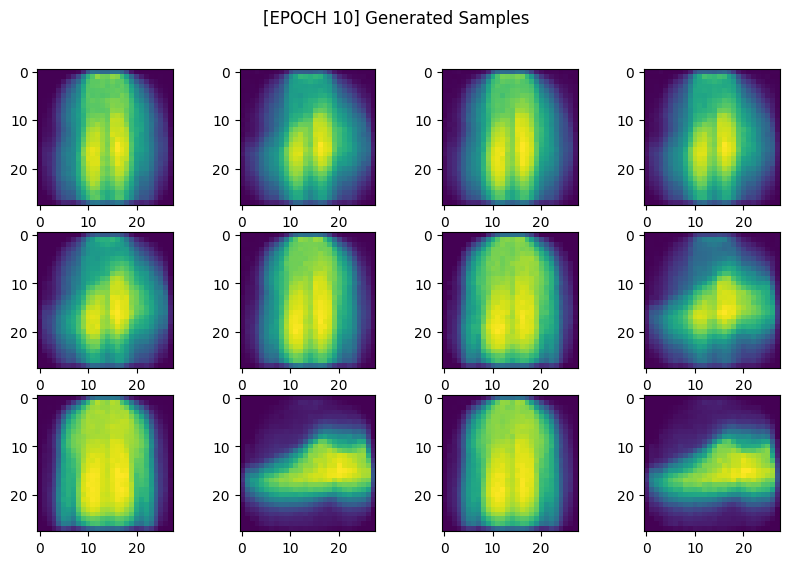

[EPOCH 10] SAMPLED TRAINING LOSS : 0.33779083633982043


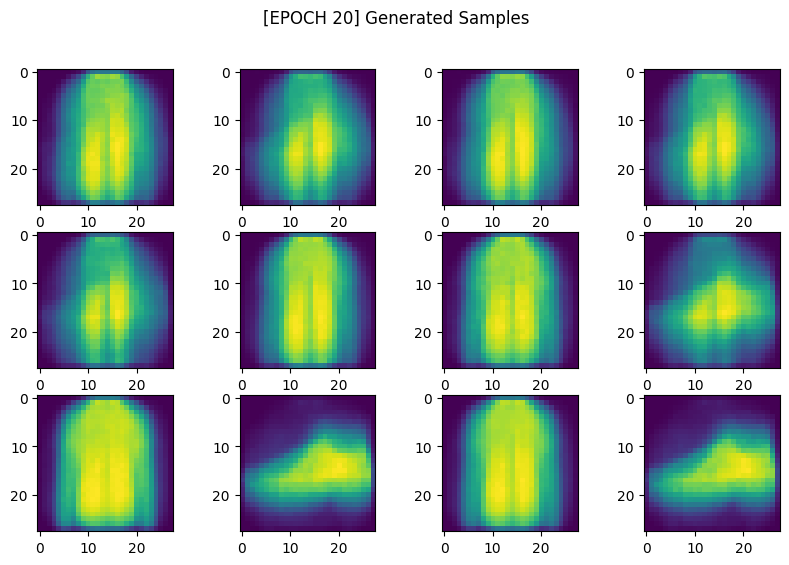

[EPOCH 20] SAMPLED TRAINING LOSS : 0.33767284093889327


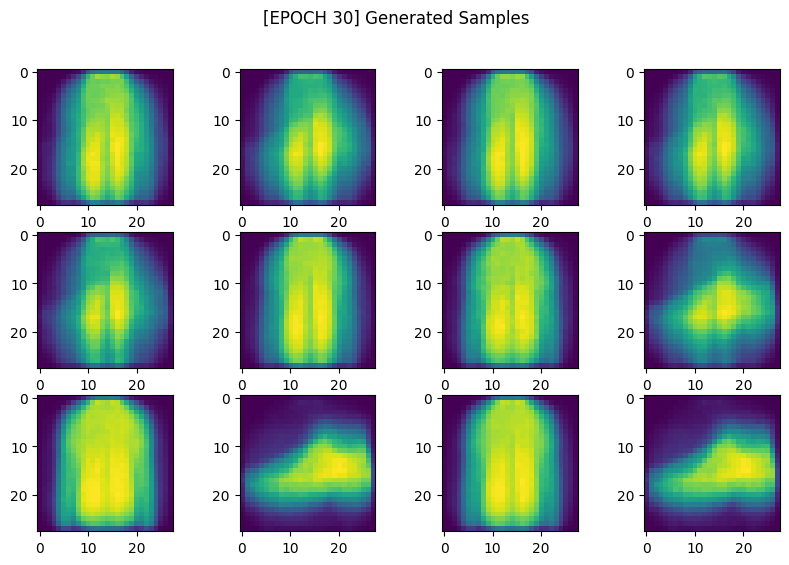

[EPOCH 30] SAMPLED TRAINING LOSS : 0.337551816567175


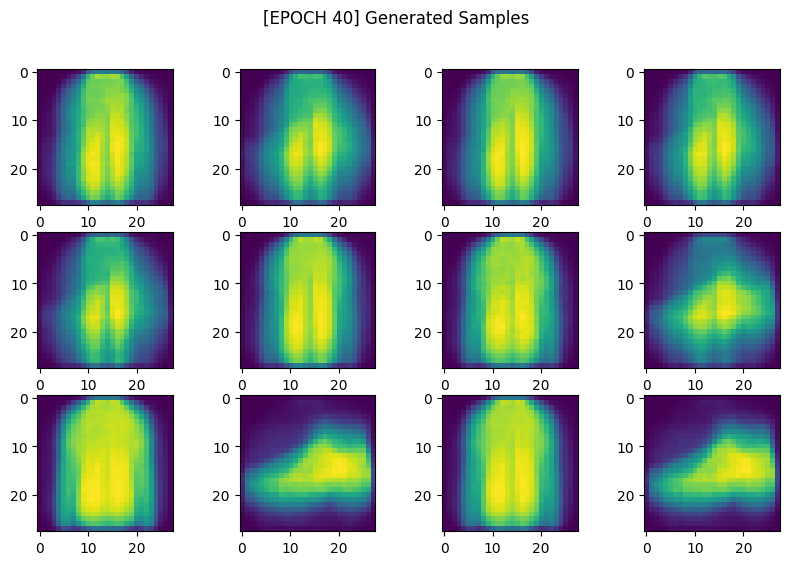

[EPOCH 40] SAMPLED TRAINING LOSS : 0.33747576008727526


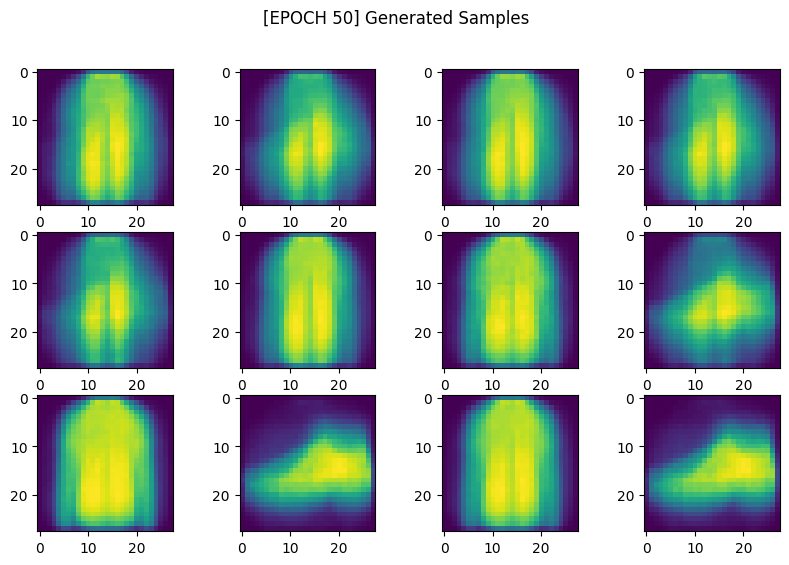

[EPOCH 50] SAMPLED TRAINING LOSS : 0.33742749710072817


In [15]:
max_epoch = 50
draw_epochs = [10, 20, 30, 40, 50]
MSE_loss_list, KL_loss_list = [],[]

for epoch in tqdm(range(max_epoch)):
    ###Train Phase

    # Initialize Loss
    train_loss = 0.0
    MSE_loss_epoch = 0
    KL_loss_epoch = 0
    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_loader):
        curr_loss, MSE_loss, KL_loss = train_vae(model, optimizer, sample)
        train_loss += curr_loss / len(train_loader)
        MSE_loss_epoch += MSE_loss / len(train_loader)
        KL_loss_epoch += KL_loss / len(train_loader)

    MSE_loss_list.append(MSE_loss_epoch)
    KL_loss_list.append(KL_loss_epoch)

    if (epoch + 1) in draw_epochs:
        fig, axes = plt.subplots(3, 4, figsize=(10, 6))
        idx = 0
        for i in range(3):
          for j in range(4):
            axes[i,j].imshow(test_vae(model, seed=idx))
            idx += 1
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch + 1))
        plt.pause(0.1)

        print('[EPOCH {}] SAMPLED TRAINING LOSS : {}'.format(epoch + 1, train_loss))

## Loss Curves for MSE and KL

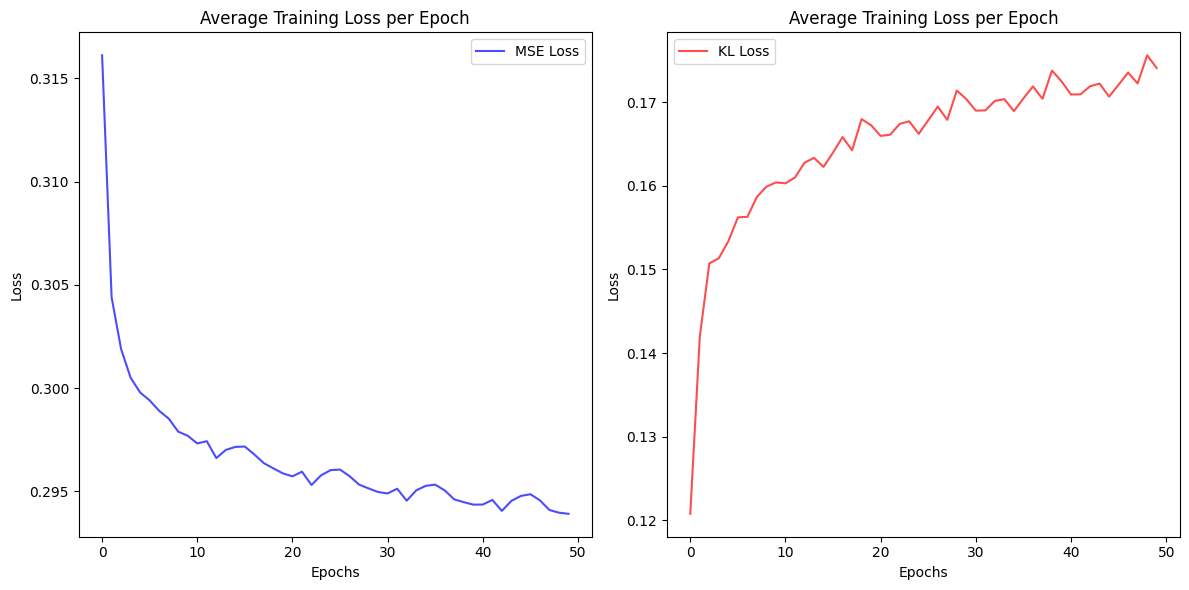

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(MSE_loss_list, label='MSE Loss', color = 'b', alpha=0.7)
axes[1].plot(KL_loss_list, label='KL Loss', color = 'r', alpha=0.7)
for i in range(2):
  axes[i].set_xlabel('Epochs')
  axes[i].set_ylabel('Loss')
  axes[i].set_title('Average Training Loss per Epoch')
  axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### MLP Classifier based on VAE Encoder

In [17]:
# test dataset and loader
test_dataset = dsets.FashionMNIST(train=False, download=True, root = './', transform = transform_train)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [18]:
class MLP_Classifier(nn.Module):
  def __init__(self, dim_hidden, dim_output, dim_input = 28*28):
    super(MLP_Classifier, self).__init__()
    self.layers = nn.Sequential(nn.Linear(dim_input, dim_hidden),
                                    nn.LeakyReLU(0.01, inplace = True))
    self.output_projection = nn.Linear(dim_hidden, dim_output)

  def forward(self, img):
    batch_size = img.shape[0]
    input = img.view(batch_size, -1)
    out = self.layers(input)
    out = self.output_projection(out)
    return out


In [19]:
NUM_EPOCHS = 30
dim_hidden = 500
dim_output = 10
classifier_model = MLP_Classifier(dim_hidden, dim_output).to(device)
optimizer = optim.Adam(classifier_model.parameters(), lr=1e-4)
print(classifier_model)

MLP_Classifier(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (output_projection): Linear(in_features=500, out_features=10, bias=True)
)


In [20]:
def train_mlp(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    img = sample[0].to(device)
    label = sample[1].to(device)

    pred = model(img)

    num_correct = torch.sum(torch.argmax(pred, dim=-1) == label)

    pred_loss = criterion(pred, label)

    pred_loss.backward()

    optimizer.step()

    return pred_loss.item(), num_correct.item()


def test_mlp(model, sample):
    model.eval()

    with torch.no_grad():

        criterion = nn.CrossEntropyLoss()

        img = sample[0].to(device)
        label = sample[1].to(device)
        pred = model(img)
        num_correct = torch.sum(torch.argmax(pred, dim=-1) == label)
        pred_loss = criterion(pred, label)

    return pred_loss.item(), num_correct.item()


### Run training

In [21]:
for epoch in range(NUM_EPOCHS):
    ###Train Phase

    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0


    # Iterate over the train_dataloader
    for sample in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):

        curr_loss, num_correct = train_mlp(classifier_model, optimizer, sample)
        train_loss += curr_loss / len(train_loader)
        train_accu += num_correct / len(train_dataset)

    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for sample in test_loader:
        curr_loss, num_correct = test_mlp(classifier_model, sample)
        test_loss += curr_loss / len(test_loader)
        test_accu += num_correct / len(test_dataset)

    print('[EPOCH {}] TRAIN LOSS : {:.03f}, TEST LOSS :{:.03f}, TRAIN ACCU: {:.03f}, TEST ACCU :{:.03f}'.format(epoch + 1, train_loss, test_loss, train_accu, test_accu))

Epoch 1/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 1] TRAIN LOSS : 0.705, TEST LOSS :0.525, TRAIN ACCU: 0.769, TEST ACCU :0.816


Epoch 2/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 2] TRAIN LOSS : 0.463, TEST LOSS :0.466, TRAIN ACCU: 0.838, TEST ACCU :0.834


Epoch 3/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 3] TRAIN LOSS : 0.421, TEST LOSS :0.442, TRAIN ACCU: 0.852, TEST ACCU :0.838


Epoch 4/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 4] TRAIN LOSS : 0.392, TEST LOSS :0.416, TRAIN ACCU: 0.863, TEST ACCU :0.851


Epoch 5/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 5] TRAIN LOSS : 0.373, TEST LOSS :0.403, TRAIN ACCU: 0.869, TEST ACCU :0.856


Epoch 6/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 6] TRAIN LOSS : 0.358, TEST LOSS :0.391, TRAIN ACCU: 0.873, TEST ACCU :0.859


Epoch 7/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 7] TRAIN LOSS : 0.346, TEST LOSS :0.385, TRAIN ACCU: 0.877, TEST ACCU :0.861


Epoch 8/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 8] TRAIN LOSS : 0.334, TEST LOSS :0.372, TRAIN ACCU: 0.881, TEST ACCU :0.868


Epoch 9/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 9] TRAIN LOSS : 0.324, TEST LOSS :0.369, TRAIN ACCU: 0.885, TEST ACCU :0.868


Epoch 10/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 10] TRAIN LOSS : 0.316, TEST LOSS :0.361, TRAIN ACCU: 0.886, TEST ACCU :0.871


Epoch 11/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 11] TRAIN LOSS : 0.308, TEST LOSS :0.357, TRAIN ACCU: 0.891, TEST ACCU :0.870


Epoch 12/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 12] TRAIN LOSS : 0.300, TEST LOSS :0.358, TRAIN ACCU: 0.893, TEST ACCU :0.872


Epoch 13/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 13] TRAIN LOSS : 0.292, TEST LOSS :0.350, TRAIN ACCU: 0.896, TEST ACCU :0.874


Epoch 14/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 14] TRAIN LOSS : 0.286, TEST LOSS :0.348, TRAIN ACCU: 0.897, TEST ACCU :0.871


Epoch 15/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 15] TRAIN LOSS : 0.281, TEST LOSS :0.343, TRAIN ACCU: 0.899, TEST ACCU :0.877


Epoch 16/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 16] TRAIN LOSS : 0.275, TEST LOSS :0.339, TRAIN ACCU: 0.902, TEST ACCU :0.878


Epoch 17/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 17] TRAIN LOSS : 0.269, TEST LOSS :0.339, TRAIN ACCU: 0.905, TEST ACCU :0.878


Epoch 18/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 18] TRAIN LOSS : 0.264, TEST LOSS :0.334, TRAIN ACCU: 0.906, TEST ACCU :0.877


Epoch 19/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 19] TRAIN LOSS : 0.259, TEST LOSS :0.330, TRAIN ACCU: 0.908, TEST ACCU :0.880


Epoch 20/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 20] TRAIN LOSS : 0.254, TEST LOSS :0.330, TRAIN ACCU: 0.909, TEST ACCU :0.881


Epoch 21/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 21] TRAIN LOSS : 0.251, TEST LOSS :0.330, TRAIN ACCU: 0.911, TEST ACCU :0.880


Epoch 22/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 22] TRAIN LOSS : 0.246, TEST LOSS :0.326, TRAIN ACCU: 0.913, TEST ACCU :0.883


Epoch 23/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 23] TRAIN LOSS : 0.241, TEST LOSS :0.325, TRAIN ACCU: 0.914, TEST ACCU :0.882


Epoch 24/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 24] TRAIN LOSS : 0.237, TEST LOSS :0.327, TRAIN ACCU: 0.915, TEST ACCU :0.882


Epoch 25/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 25] TRAIN LOSS : 0.232, TEST LOSS :0.320, TRAIN ACCU: 0.918, TEST ACCU :0.883


Epoch 26/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 26] TRAIN LOSS : 0.229, TEST LOSS :0.323, TRAIN ACCU: 0.919, TEST ACCU :0.885


Epoch 27/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 27] TRAIN LOSS : 0.225, TEST LOSS :0.318, TRAIN ACCU: 0.920, TEST ACCU :0.885


Epoch 28/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 28] TRAIN LOSS : 0.223, TEST LOSS :0.317, TRAIN ACCU: 0.921, TEST ACCU :0.883


Epoch 29/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 29] TRAIN LOSS : 0.218, TEST LOSS :0.316, TRAIN ACCU: 0.923, TEST ACCU :0.887


Epoch 30/30:   0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 30] TRAIN LOSS : 0.215, TEST LOSS :0.316, TRAIN ACCU: 0.924, TEST ACCU :0.886


### Use pretrained hidden layer of the classifier in the VAE Encoder

In [22]:
print(classifier_model)

MLP_Classifier(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (output_projection): Linear(in_features=500, out_features=10, bias=True)
)


In [35]:
classifier_model.layers[0].weight

Parameter containing:
tensor([[ 0.0077,  0.0155,  0.0075,  ...,  0.0122, -0.0352, -0.0285],
        [-0.0263, -0.0013, -0.0224,  ...,  0.0205, -0.0379, -0.0274],
        [-0.0162,  0.0245, -0.0260,  ..., -0.0194, -0.0119, -0.0220],
        ...,
        [-0.0204,  0.0012, -0.0181,  ..., -0.0501, -0.0552,  0.0111],
        [ 0.0157,  0.0081,  0.0241,  ...,  0.0199, -0.0071, -0.0345],
        [-0.0159, -0.0253,  0.0206,  ...,  0.0113,  0.0091, -0.0149]],
       device='cuda:0', requires_grad=True)

In [41]:
dim_hidden = 500
dim_z = 2
encoder = Encoder(dim_hidden, dim_z)
decoder = Decoder(dim_hidden,dim_z)


model = VAEMLP(encoder, decoder, dim_hidden, dim_z, classifier_model)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

initialize weights from pretrained classifier: dict_keys(['layers.0.weight', 'layers.0.bias'])
VAEMLP(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (z_mean): Linear(in_features=500, out_features=2, bias=True)
    (z_logvar): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=500, out_features=784, bias=True)
    )
  )
)


  0%|          | 0/50 [00:00<?, ?it/s]

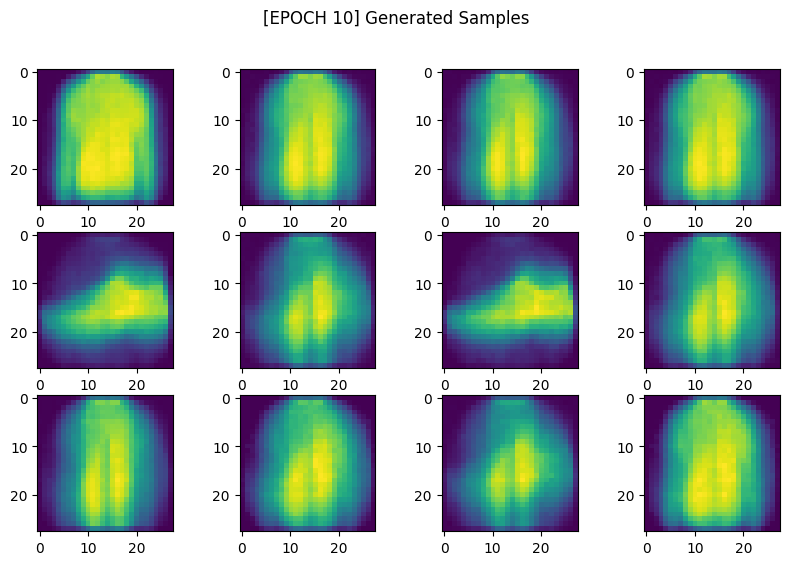

[EPOCH 10] SAMPLED TRAINING LOSS : 0.338585211587613


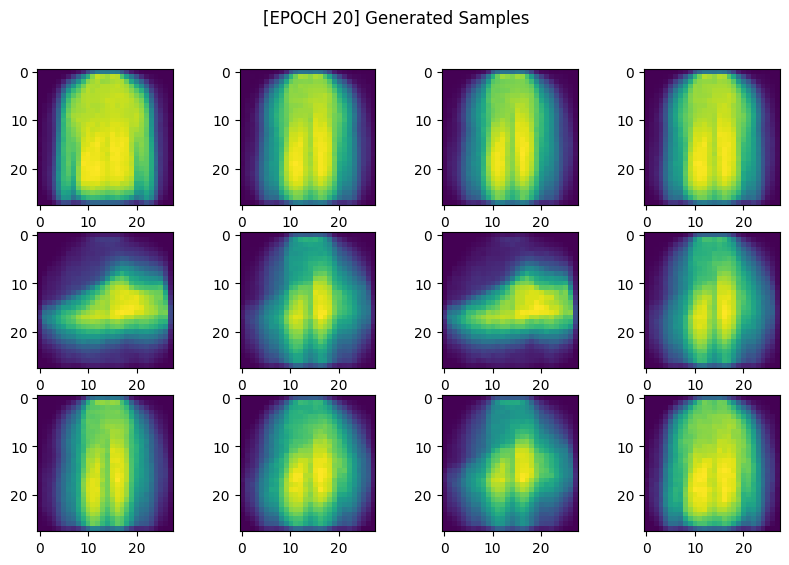

[EPOCH 20] SAMPLED TRAINING LOSS : 0.33759186707580013


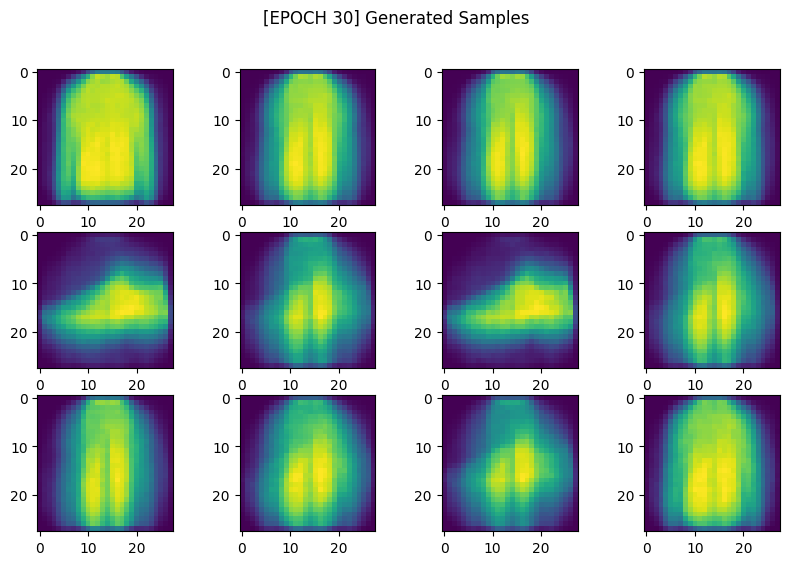

[EPOCH 30] SAMPLED TRAINING LOSS : 0.33738422489115466


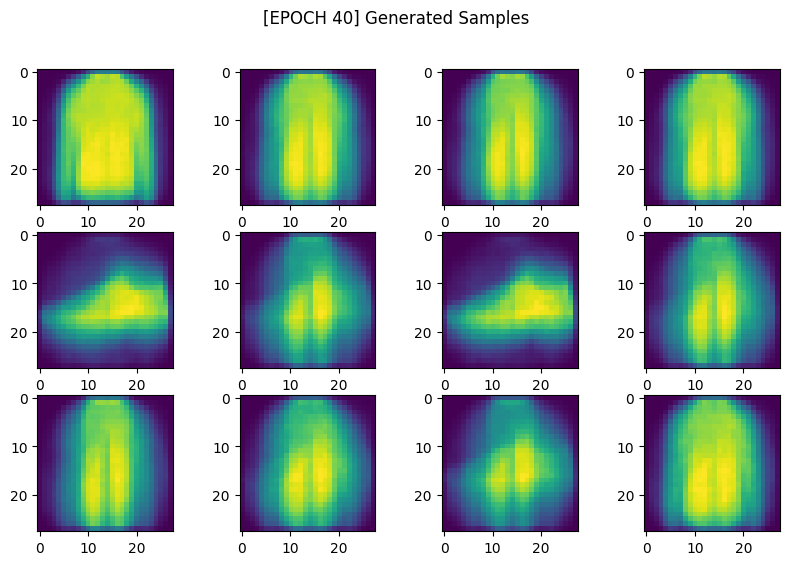

[EPOCH 40] SAMPLED TRAINING LOSS : 0.33726858171318597


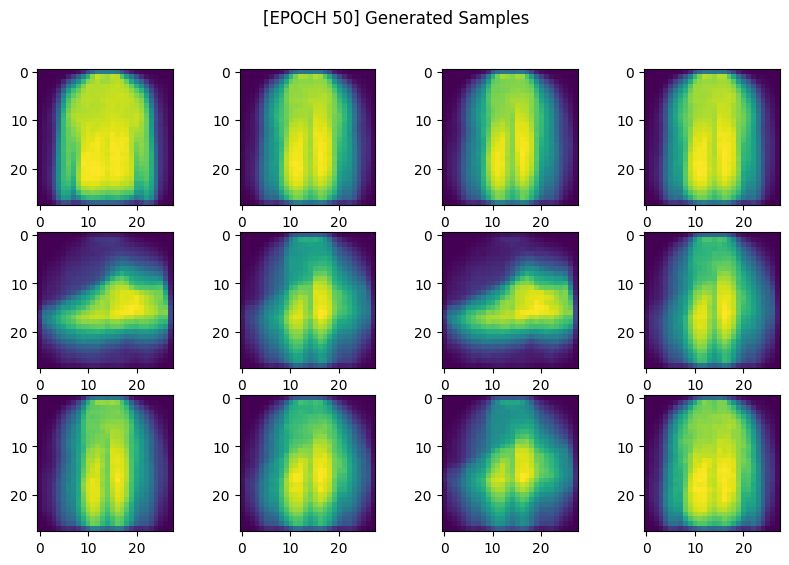

[EPOCH 50] SAMPLED TRAINING LOSS : 0.33719472545804785


In [42]:
max_epoch = 50
draw_epochs = [10, 20, 30, 40, 50]
MSE_loss_list, KL_loss_list = [],[]

for epoch in tqdm(range(max_epoch)):
    ###Train Phase

    # Initialize Loss
    train_loss = 0.0
    MSE_loss_epoch = 0
    KL_loss_epoch = 0
    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_loader):
        curr_loss, MSE_loss, KL_loss = train_vae(model, optimizer, sample)
        train_loss += curr_loss / len(train_loader)
        MSE_loss_epoch += MSE_loss / len(train_loader)
        KL_loss_epoch += KL_loss / len(train_loader)

    MSE_loss_list.append(MSE_loss_epoch)
    KL_loss_list.append(KL_loss_epoch)

    if (epoch + 1) in draw_epochs:
        fig, axes = plt.subplots(3, 4, figsize=(10, 6))
        idx = 0
        for i in range(3):
          for j in range(4):
            axes[i,j].imshow(test_vae(model, seed=idx))
            idx += 1
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch + 1))
        plt.pause(0.1)

        print('[EPOCH {}] SAMPLED TRAINING LOSS : {}'.format(epoch + 1, train_loss))

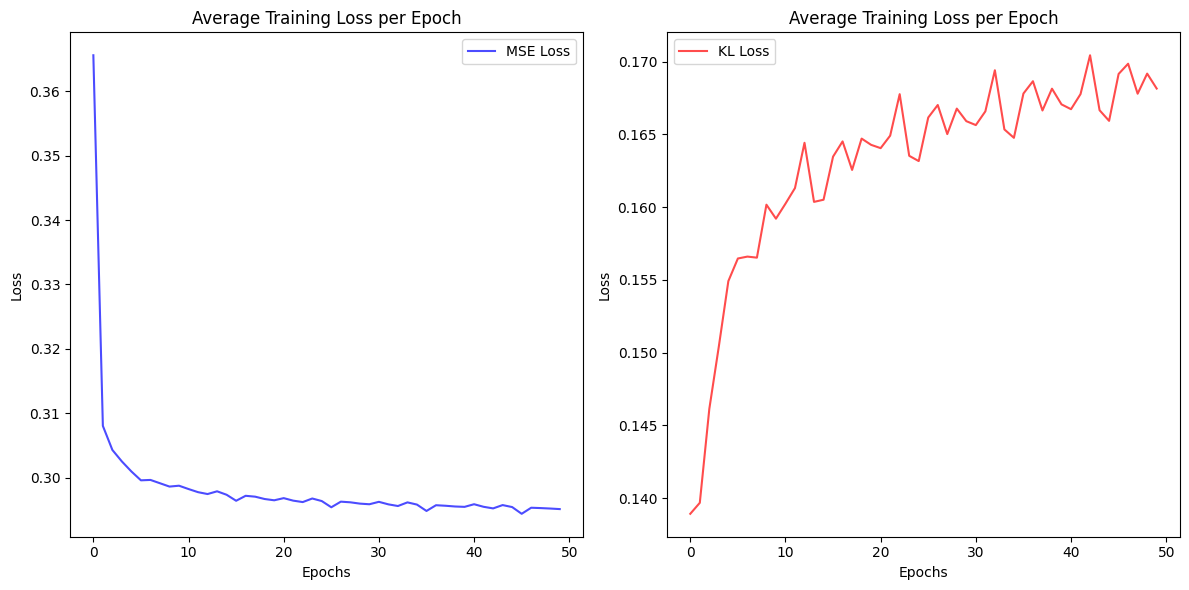

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(MSE_loss_list, label='MSE Loss', color = 'b', alpha=0.7)
axes[1].plot(KL_loss_list, label='KL Loss', color = 'r', alpha=0.7)
for i in range(2):
  axes[i].set_xlabel('Epochs')
  axes[i].set_ylabel('Loss')
  axes[i].set_title('Average Training Loss per Epoch')
  axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()